In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# ========== 1) 下载数据并处理频率 ==========
df = yf.download("AAPL", start="2020-01-01", end="2025-3-20")

# 索引改为 DateTime，并设置成业务日频率(B)
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')

# 对缺失值(周末/节假日)进行填充：用前一个交易日的收盘价
df['Close'] = df['Close'].ffill()

print("数据集前几行：")
print(df.head(10))
print("数据集索引频率：", df.index.freq)

# 取 'Close' 作为预测目标
data = df["Close"].dropna()

[*********************100%***********************]  1 of 1 completed

数据集前几行：
Price           Close       High        Low       Open       Volume
Ticker           AAPL       AAPL       AAPL       AAPL         AAPL
Date                                                               
2020-01-02  72.716057  72.776583  71.466797  71.721004  135480400.0
2020-01-03  72.009109  72.771737  71.783954  71.941321  146322800.0
2020-01-06  72.582909  72.621646  70.876075  71.127866  118387200.0
2020-01-07  72.241547  72.849224  72.021231  72.592594  108872000.0
2020-01-08  73.403648  73.706279  71.943759  71.943759  132079200.0
2020-01-09  74.962799  75.156480  74.132383  74.384166  170108400.0
2020-01-10  75.132263  75.698794  74.628689  75.197636  140644800.0
2020-01-13  76.737411  76.764047  75.330785  75.449422  121532000.0
2020-01-14  75.701218  76.885112  75.577749  76.674482  161954400.0
2020-01-15  75.376801  76.383956  74.943431  75.500276  121923600.0
数据集索引频率： <BusinessDay>


In [37]:
# ========== 2) 训练/测试集划分 ========== 
# 这里示例：最后30个交易日当做测试集
train_data = data.iloc[:-30]
test_data  = data.iloc[-30:]

# ========== 3) ARIMA 模型训练 & 测试 ==========
model_arima = ARIMA(train_data, order=(5, 1, 0))  # p,d,q = (5,1,0)仅作示例
model_fit_arima = model_arima.fit()

# 在测试集长度(30天)上做预测
forecast_test_arima = model_fit_arima.forecast(steps=30)

# 评估 ARIMA 预测在测试集上的 MAE、RMSE
mae_arima = mean_absolute_error(test_data, forecast_test_arima)
rmse_arima = math.sqrt(mean_squared_error(test_data, forecast_test_arima))

print("\n=== ARIMA 测试集表现 ===")
print("Test MAE:", mae_arima)
print("Test RMSE:", rmse_arima)

# 如果 forecast_test_arima 索引不是和 test_data 一致，可以手动重置一下：
# （statsmodels 版本如果能自动识别频率，则它会返回带日期的 Series，如果不是，就要手动对齐）
if not forecast_test_arima.index.equals(test_data.index):
    forecast_test_arima = pd.Series(forecast_test_arima.values, index=test_data.index)


=== ARIMA 测试集表现 ===
Test MAE: 10.196397478154942
Test RMSE: 11.738271779572411


In [38]:
# ========== 4) LSTM 模型训练 & 测试 ==========
# 4.1 数据归一化 + 生成滚动窗口 (X, y)
def create_sequences(dataset, look_back=20):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back])
    return np.array(X), np.array(y)

look_back = 20
close_values = data.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(close_values)

train_size = len(scaled_values) - 30
train_scaled = scaled_values[:train_size]
test_scaled  = scaled_values[train_size - look_back:]  # 多取一个窗口

X_train, y_train = create_sequences(train_scaled, look_back)
X_test,  y_test  = create_sequences(test_scaled,  look_back)

print("\nLSTM X_train.shape =", X_train.shape, " y_train.shape =", y_train.shape)
print("LSTM X_test.shape  =", X_test.shape,  " y_test.shape  =", y_test.shape)

# 4.2 构建LSTM网络并训练
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

model_lstm.fit(
    X_train, y_train,
    epochs=10,        # 示例，实际可调大
    batch_size=32,
    verbose=1
)

# 4.3 测试集预测
y_pred_test_scaled = model_lstm.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test_scaled)   # LSTM预测值(逆缩放)
y_test_inv  = scaler.inverse_transform(y_test.reshape(-1,1)) # 测试集真实值(逆缩放)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_test)
rmse_lstm = math.sqrt(mean_squared_error(y_test_inv, y_pred_test))

print("\n=== LSTM 测试集表现 ===")
print("Test MAE:", mae_lstm)
print("Test RMSE:", rmse_lstm)

# 同样，把 LSTM 预测值放进 Series 并对齐 test_data.index
lstm_pred_series = pd.Series(y_pred_test.flatten(), index=test_data.index)



LSTM X_train.shape = (1310, 20, 1)  y_train.shape = (1310, 1)
LSTM X_test.shape  = (30, 20, 1)  y_test.shape  = (30, 1)
Epoch 1/10


/Users/Winfred/anaconda3/envs/dl/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0725
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7932e-04
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9080e-04
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0732e-04
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8701e-04
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5002e-04
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8823e-04
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2607e-04
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6113e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

=== LSTM 测试集表现 ===
Test MAE: 8.492959594726566
Test RMSE: 10.220722256795856


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun


==== 测试集指标对比 ====
ARIMA - MAE: 10.1964, RMSE: 11.7383
LSTM  - MAE: 8.4930, RMSE: 10.2207


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

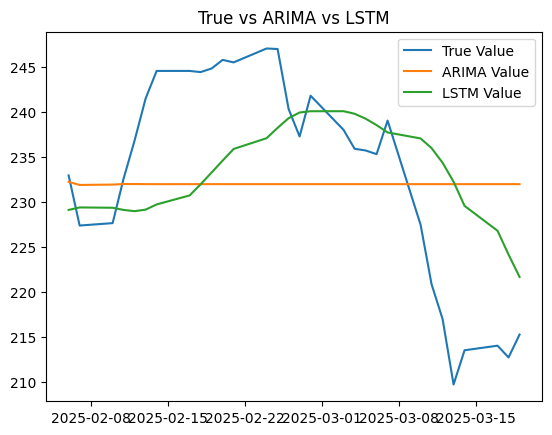

In [39]:
# ========== 5) 对比: 测试集真实值 vs ARIMA vs LSTM ==========
print("\n==== 测试集指标对比 ====")
print(f"ARIMA - MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")
print(f"LSTM  - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")


plt.figure()
plt.plot(test_data.index, test_data, label='True Value')
plt.plot(forecast_test_arima.index, forecast_test_arima, label='ARIMA Value')
plt.plot(lstm_pred_series.index, lstm_pred_series, label='LSTM Value')
plt.title('True vs ARIMA vs LSTM')
plt.legend()
plt.show()


In [ ]:
# ========== 6)：预测未来 7 天 ==========

print("\n=== ARIMA 未来7个交易日预测 ===")
arima_future_7 = model_fit_arima.forecast(steps=7)
print(arima_future_7)

print("\n=== LSTM 未来7个交易日预测 ===")
last_sequence = scaled_values[-look_back:]
predictions_7d = []
current_seq = last_sequence.copy()

for i in range(7):
    input_seq = np.expand_dims(current_seq, axis=0)
    pred_scaled = model_lstm.predict(input_seq)
    pred_value = scaler.inverse_transform(pred_scaled)[0,0]
    predictions_7d.append(pred_value)
    current_seq = np.vstack((current_seq[1:], pred_scaled))

print(predictions_7d)


=== ARIMA 未来7个交易日预测 ===
2025-02-06    232.245014
2025-02-07    231.900665
2025-02-10    231.942705
2025-02-11    232.001140
2025-02-12    232.003490
2025-02-13    231.992256
2025-02-14    231.987780
Freq: B, Name: predicted_mean, dtype: float64

=== LSTM 未来7个交易日预测(滚动) ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[219.53822, 218.00093, 216.87576, 216.04068, 215.40279, 214.88515, 214.44852]
